**현빈 작성**

In [ ]:
!gdown https://drive.google.com/uc?id=1jonSjJhywVMYHel3u8XNUQH684VyneWf
!unzip -o sample.zip
!rm sample.zip

Downloading...
From: https://drive.google.com/uc?id=1jonSjJhywVMYHel3u8XNUQH684VyneWf
To: /content/sample.zip
100% 568M/568M [00:09<00:00, 60.2MB/s]
Archive:  sample.zip
  inflating: ffhq_samples/00713.png  
  inflating: ffhq_samples/00733.png  
  inflating: ffhq_samples/00855.png  
  inflating: ffhq_samples/00394.png  
  inflating: ffhq_samples/00633.png  
  inflating: ffhq_samples/00829.png  
  inflating: ffhq_samples/00398.png  
  inflating: ffhq_samples/00490.png  
  inflating: ffhq_samples/00566.png  
  inflating: ffhq_samples/00525.png  
  inflating: ffhq_samples/00952.png  
  inflating: ffhq_samples/00646.png  
  inflating: ffhq_samples/00779.png  
  inflating: ffhq_samples/00949.png  
  inflating: ffhq_samples/00466.png  
  inflating: ffhq_samples/00559.png  
  inflating: ffhq_samples/00392.png  
  inflating: ffhq_samples/00581.png  
  inflating: ffhq_samples/00897.png  
  inflating: ffhq_samples/00730.png  
  inflating: ffhq_samples/00756.png  
  inflating: ffhq_samples/00396.

In [ ]:
!pip install onnxruntime-gpu
!pip install -U insightface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111.0 MB 46 kB/s 
     |████████████████████████████████| 46 kB 4.7 MB/s 
     |████████████████████████████████| 86 kB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 433 kB 15.8 MB/s 
     |████████████████████████████████| 13.1 MB 59.1 MB/s 
  Created wheel for insightface: filename=insightface-0.6.2-cp37-cp37m-linux_x86_64.whl size=983342 sha256=262afd711c66454d66bfca7c7021c4eefa7180770acf4cf80d2e599e0c4dbddf
  Stored in directory: /root/.cache/pip/wheels/ae/2f/ee/b7883684f81f184dc1e571424108144d3cf7716290f04781c0
Successfully built insightface


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

app = FaceAnalysis(allowed_modules=['detection'], providers=['CUDAExecutionProvider', 'CPUExecutionProvider']) 
app.prepare(ctx_id=0, det_size=(640, 640))
img = cv2.imread('/content/ffhq_samples/00000.png')
faces = app.get(img)
rimg = app.draw_on(img, faces)
output = cv2.imwrite("output00000.jpg", rimg)

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [04:34<00:00, 1025.45KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'cudnn_conv_use_max_workspace': '0', 'enable_cuda_graph': '0', 'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0'}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'cudnn_conv_use_max_workspace': '0', 'enable_cuda_graph': '0', 'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '1844674

In [ ]:
import cv2
import numpy as np
from skimage import transform as trans

arcface_src = np.array(
    [[38.2946, 51.6963], [73.5318, 51.5014], [56.0252, 71.7366],
     [41.5493, 92.3655], [70.7299, 92.2041]],
    dtype=np.float32)

arcface_src = np.expand_dims(arcface_src, axis=0)

def estimate_norm(lmk, image_size=112, mode='arcface'):
    assert lmk.shape == (5, 2)
    tform = trans.SimilarityTransform()
    lmk_tran = np.insert(lmk, 2, values=np.ones(5), axis=1)
    min_M = []
    min_index = []
    min_error = float('inf')
    if mode == 'arcface':
        if image_size == 112:
            src = arcface_src
        else:
            src = float(image_size) / 112 * arcface_src
    else:
        src = src_map[image_size]
    for i in np.arange(src.shape[0]):
        tform.estimate(lmk, src[i])
        M = tform.params[0:2, :]
        results = np.dot(M, lmk_tran.T)
        results = results.T
        error = np.sum(np.sqrt(np.sum((results - src[i])**2, axis=1)))
        #         print(error)
        if error < min_error:
            min_error = error
            min_M = M
            min_index = i
    return min_M, min_index


def norm_crop(img, kpss, image_size=112, mode='arcface'):
    M, pose_index = estimate_norm(kpss, image_size, mode)
    warped = cv2.warpAffine(img, M, (image_size, image_size), borderValue=0.0)
    return warped

In [ ]:
kpss = faces[0]['kps']

In [ ]:
cropped = norm_crop(img, kpss, image_size=112, mode='arcface')

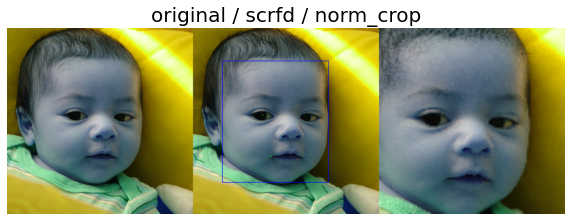

In [ ]:
cropped = cv2.resize(cropped, dsize=(1024, 1024))

compare = np.concatenate((img, rimg, cropped),1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title("original  /  scrfd  /  norm_crop", fontsize=20)
plt.axis('off')
plt.show()